# DeLA Interactive Notebook

Created by: Maosheng Jiang

This notebook is a supplementary educational tool to illustrate how the spatial-regularizer works in the paper: [Decoupled Local Aggregation for Point Cloud Learning](https://arxiv.org/abs/2308.16532).

## Preliminaries 

Traditional local aggregators (e.g. DGCNN, PointNet++) will, at each aggregation layer, recalculate the neighbors in the feature space or in the coordinate space. If a lot of aggregation layers are stacked, then this will become computationally expensive. Decoupled Local Aggregation (DeLA) proposes Decoupled Local Aggregation: we compute and encode the neighbourhood of points beforehand and avoid recomputing this in each successive layer.

![Traditional Aggregation vs Decoupled Local Aggregation](local_aggregation.png)

In the image above, we can see that in the case of DeLA, we only compute the neighborhood once (which then gets encoded within the point features), and the subsequent layer do not have to recompute the neighborhood again.

The downside of this, is that the encoding of the relative distance may degrade deeper into the layers. For that, we employ a spatial regularization term, which essentially trains a small MLP in parallel to keep the encoded relative distance intact within an aggregation layer. This is exactly the technique that we are going to explore in this notebook. For more information about DeLA, please refer to the original paper.

First, let's import the required libraries:

In [92]:
import numpy as np
import pandas as pd
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim

## Practical example

To illustrate the regularization term, we will train a simple point cloud network to classify 2D point clouds of handwritten digits (MNIST). This dataset contains 60000 2D point clouds , each consisting of a maximum of 351 2D points with a corresponding value which specifies how large a point is. The test set contains 10000 2D point clouds. For more information, refer to the kaggle source: https://www.kaggle.com/datasets/cristiangarcia/pointcloudmnist2d/data

Now, let's get familiar with the dataset and load it:

In [93]:
TRAIN_PATH = Path("archive/train.csv")
TEST_PATH = Path("archive/test.csv")


def read_data(path):
    return pd.read_csv(path)


def preprocess_data(df):
    X = df[df.columns[1:]].to_numpy()
    y = df[df.columns[0]].to_numpy()

    X = X.reshape((X.shape[0], 351, 3))
    X = X[:, :, :-1] # Drop the value column (not needed)
    y = y.reshape(y.shape[0], 1)

    # X: [60000, 351, 3], y: [60000, 1]
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

X_train, y_train = preprocess_data(read_data(TRAIN_PATH))
X_test, y_test = preprocess_data(read_data(TEST_PATH))

All point clouds have a fixed number of points (351). This is because it is the maximum number of points found in a single point cloud of the dataset. If a point cloud has less than 351 points, then the rest of the points are masked out as -1. So we need to account for this.

Let's visualize a point cloud!

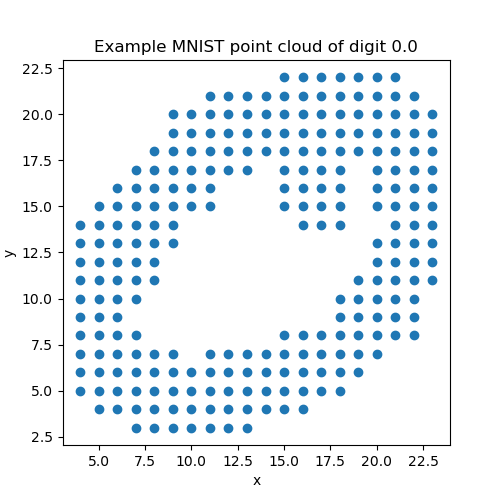

In [94]:
%matplotlib widget

idx = np.random.randint(X_train.shape[0])

coords = X_train[idx]

# Keep only the real points (where x != -1 and y != -1)
coords = coords[(coords[:, 0] != -1) & (coords[:, 1] != -1)]
label = y_train[idx].item()

plt.figure(figsize=(5,5))
plt.scatter(coords[:, 0], coords[:, 1])
plt.title(f"Example MNIST point cloud of digit {label}")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Now we have the MNIST 2D point clouds, let's make the data loader for the train and test dataset.

In [95]:
class PointCloudDataset(Dataset):
    def __init__(self, X, y):
        """
        X: [num_samples, 351, 2] 
        y: [num_samples, 1]
        """
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, item):
        coords = self.X[item]
        label = self.y[item]

        # Keep only the real points (where x != -1 and y != -1)
        coords = coords[(coords[:, 0] != -1) & (coords[:, 1] != -1)]

        return coords, label


# Since the point clouds have variable amount of points, we cannot use default batching.
# We need to implement a custom collate_fn which will be passed into the dataloader
# to create a custom batch, which is a list of variable point clouds
def collate_fn(batch):
    coords_list = [item[0] for item in batch]
    labels      = [item[1] for item in batch]
    return coords_list, labels

In [96]:
train_ds = PointCloudDataset(X_train, y_train)
test_ds = PointCloudDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=1, collate_fn=collate_fn, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=1, collate_fn=collate_fn, shuffle=True)

In [97]:
for i, j in train_loader:
    print(f"Batch size: {len(i)}")
    for k in i:
        print(f"shape of a batch instance: {k.shape}")
    break

Batch size: 1
shape of a batch instance: torch.Size([134, 2])


## Model

Now we have the dataloaders ready, it is time to define a basic 2D point cloud classification model with 3 local aggregation layers with global max pooling.

First we precompute the relative distances of the k neighbors of each point. We are using a basic method that first computes for each point the euclidean distance to all other points. In the original DeLA implementation, the authors used an knn algorithm with KD-Trees which is more efficient.

In [98]:
def knn_indices(x, k):
    """
    x: [N,2] point cloud
    returns indices: [N,k] tensor of neighbor indices for each point
    """
    dist = torch.cdist(x, x, p=2)
    values, indices = torch.topk(dist, k+1, largest=False, dim=-1)

    # Remove the index of its own point
    return indices[:, 1:]


# Test it out
x = torch.tensor([[0., 0.],[0., 1.],[0., 2.],[0., 3.]]) # [N, 2]
indices = knn_indices(x, 2) # [N, k]
print(indices)
rel_dist = x[indices] - x.unsqueeze(1) # [N, k, 2]
print(rel_dist)

tensor([[1, 2],
        [0, 2],
        [1, 3],
        [2, 1]])
tensor([[[ 0.,  1.],
         [ 0.,  2.]],

        [[ 0., -1.],
         [ 0.,  1.]],

        [[ 0., -1.],
         [ 0.,  1.]],

        [[ 0., -1.],
         [ 0., -2.]]])


In [99]:
class LocalAggrLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.mlp = nn.Sequential(
            nn.Linear(in_channels*2 + 2, out_channels),
            nn.ReLU(),
            nn.Linear(out_channels, out_channels)
        )
        

    def forward(self, xyz, knn, rel_dist):
        """
        xyz: [N, in_channels] point cloud
        knn: [N, k] precomputed neighbors indices
        rel_dist: [N, k, 2] relative distances
        """

        # A tensor where each point N has the features of its k neighbors
        neighbor_feat = xyz[knn] # [N, k, in_channels]

        # A tensor with features of each point
        center_feat = xyz.unsqueeze(1).expand_as(neighbor_feat) # [N, k, in_channels]

        # A tensor with relative distances of each neighbor to a point
        rel_dist = rel_dist # [N, k, 2]

        # Now we make up the final feature for each neighbor for message passing: [center_features, neighbor_features, relative_distance]
        message_feat = torch.concat([center_feat, neighbor_feat, rel_dist], dim=2) # [N, k, in_channel*2 + 2]

        result = self.mlp(message_feat) # [N, k, out_channels]

        # Now we aggregate using max (basically a MaxPool)
        values, indices = torch.max(result, dim=1)

        return values


x = LocalAggrLayer(2, 6)
t = torch.tensor([[0., 0.],[0., 1.],[0., 2.],[0., 3.]])
indices = knn_indices(t, 2)
x(torch.tensor([[0., 0.],[0., 1.],[0., 2.],[0., 3.]]), indices, t[indices] - t.unsqueeze(1))

tensor([[ 0.6892, -0.2665, -0.7055,  0.0962,  0.6998,  0.3795],
        [ 0.5090, -0.1421, -0.4506, -0.1119,  0.6203,  0.3818],
        [ 0.4941, -0.0745, -0.5489, -0.1738,  0.6679,  0.4282],
        [ 0.3262, -0.2003, -0.5690, -0.3509,  0.5946,  0.5427]],
       grad_fn=<MaxBackward0>)

In [100]:
class GNN3Layer(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.layer1 = LocalAggrLayer(in_channels, hidden_channels)
        self.layer2 = LocalAggrLayer(hidden_channels, hidden_channels)
        self.layer3 = LocalAggrLayer(hidden_channels, out_channels)
        self.fc = nn.Linear(out_channels, 10) # 10 classes for MNIST

    
    def forward(self, xyz, knn, rel_dist):
        x = self.layer1(xyz, knn, rel_dist)
        x = self.layer2(x, knn, rel_dist)
        x = self.layer3(x, knn, rel_dist)
        
        # Apply global max pooling
        x, _ = torch.max(x, dim=0)

        # Final classification head
        x = self.fc(x)

        return x


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
in_channels = 2
hidden_channels = 64
out_channels = 64
k_neighbors = 5
learning_rate = 0.001
epochs = 1

model = GNN3Layer(in_channels, hidden_channels, out_channels).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Train the model
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for points, labels in train_loader:
        # Initialize loss for the batch
        batch_loss = 0.0
        correct_in_batch = 0


        for i in range(len(points)):  # Iterate over each point cloud in the batch
            point_cloud = points[i].to(device)  # [var, 2] (the point cloud)
            label = labels[i].to(device)  # The label of the point cloud

            # Prepare the data (knn and relative distances)
            knn = knn_indices(point_cloud, k_neighbors)

            rel_dist = point_cloud[knn] - point_cloud.unsqueeze(1)

            # Forward pass for the individual point cloud
            outputs = model(point_cloud, knn, rel_dist)     
            
            # Compute loss for the point cloud
            loss = criterion(outputs.unsqueeze(0), label.long())
            batch_loss += loss
            
            # Compute the accuracy for the point cloud
            _, predicted = torch.max(outputs, dim=0)
            if predicted == label:
                correct_in_batch += 1

        # Accumulate batch loss and accuracy
        running_loss += batch_loss
        correct += correct_in_batch
        total += len(points)

        # Backpropagation after processing the entire batch
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        if total % 3200 == 0:   
            print(f"{total}/60000, Accuracy: {100*correct/total:.2f}%")

    # Print training stats
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100*correct/total:.2f}%')



KeyboardInterrupt: 

As we have seen, the above code work fine and we get reasonable accuracy. As mentioned, the downside is the requirement of feeding the relative distances in each layer. DeLA proposes a different way of local aggregation.

In [101]:
class DecoupledLocalAggrLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        # Feature aggregation MLP
        self.mlp = nn.Sequential(
            nn.Linear(in_channels*2, out_channels),
            nn.ReLU(),
            nn.Linear(out_channels, out_channels)
        )

        self.cor_head_hidden_dim = 16

        # Prediction MLP for predicting relative coordinates
        self.pred_mlp = nn.Sequential(
            nn.Linear(out_channels, self.cor_head_hidden_dim),
            nn.ReLU(),
            nn.Linear(self.cor_head_hidden_dim, 2)
        )
        

    def forward(self, xyz, knn, rel_dist):
        """
        xyz: [N, in_channels] point cloud
        knn: [N, k] precomputed neighbors indices
        rel_dist: [N, k, 2] relative distances
        """

        # A tensor where each point N has the features of its k neighbors
        neighbor_feat = xyz[knn] # [N, k, in_channels]

        # A tensor with features of each point
        center_feat = xyz.unsqueeze(1).expand_as(neighbor_feat) # [N, k, in_channels]

        # Now we make up the final feature for each neighbor for message passing: [center_features, neighbor_features]
        message_feat = torch.concat([center_feat, neighbor_feat], dim=2) # [N, k, in_channel*2]

        result = self.mlp(message_feat) # [N, k, out_channels]
        
        # Regularization
        if self.training:
            pred_rel = self.pred_mlp(result) # Outputs the predicted relative distance between each center node and neighbor: [N, k, 2] 
            reg_loss = nn.functional.mse_loss(pred_rel, rel_dist)
        else:
            reg_loss = 0
        
        # Now we aggregate using max (basically a MaxPool)
        values, indices = torch.max(result, dim=1)

        return values, reg_loss


x = LocalAggrLayer(2, 6)
t = torch.tensor([[0., 0.],[0., 1.],[0., 2.],[0., 3.]])
indices = knn_indices(t, 2)
x(torch.tensor([[0., 0.],[0., 1.],[0., 2.],[0., 3.]]), indices, t[indices] - t.unsqueeze(1))

tensor([[-0.2109, -0.0898,  0.1688,  0.0277,  0.1127, -0.3338],
        [-0.1493,  0.1290, -0.1045, -0.1392, -0.1987, -0.2783],
        [-0.3101,  0.1735, -0.3581, -0.2682, -0.4241, -0.2250],
        [-0.4775,  0.2221, -0.5190, -0.3169, -0.5122, -0.1958]],
       grad_fn=<MaxBackward0>)

In [109]:
class GNN3Layer(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.layer1 = DecoupledLocalAggrLayer(in_channels, hidden_channels)
        self.layer2 = DecoupledLocalAggrLayer(hidden_channels, hidden_channels)
        self.layer3 = DecoupledLocalAggrLayer(hidden_channels, out_channels)
        self.fc = nn.Linear(out_channels, 10) # 10 classes for MNIST

    
    def forward(self, xyz, knn, rel_dist):
        x, reg_loss1 = self.layer1(xyz, knn, rel_dist)
        x, reg_loss2 = self.layer2(x, knn, rel_dist)
        x, reg_loss3 = self.layer3(x, knn, rel_dist)
        
        # Apply global max pooling
        x, _ = torch.max(x, dim=0)

        # Final classification head
        x = self.fc(x)

        total_reg_loss = reg_loss1 + reg_loss2 + reg_loss3

        return x, total_reg_loss


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
in_channels = 2
hidden_channels = 32
out_channels = 32
k_neighbors = 5
learning_rate = 0.001
epochs = 1

model = GNN3Layer(in_channels, hidden_channels, out_channels).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Train the model
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for points, labels in train_loader:
        # Initialize loss for the batch
        batch_loss = 0.0
        correct_in_batch = 0


        for i in range(len(points)):  # Iterate over each point cloud in the batch
            point_cloud = points[i].to(device)  # [var, 2] (the point cloud)
            label = labels[i].to(device)  # The label of the point cloud

            # Prepare the data (knn and relative distances)
            knn = knn_indices(point_cloud, k_neighbors)

            rel_dist = point_cloud[knn] - point_cloud.unsqueeze(1)

            # Forward pass for the individual point cloud
            outputs, reg_loss = model(point_cloud, knn, rel_dist)     
            
            # Compute loss for the point cloud
            loss = criterion(outputs.unsqueeze(0), label.long())
            batch_loss += loss + reg_loss
            
            # Compute the accuracy for the point cloud
            _, predicted = torch.max(outputs, dim=0)
            if predicted == label:
                correct_in_batch += 1

        # Accumulate batch loss and accuracy
        running_loss += batch_loss
        correct += correct_in_batch
        total += len(points)

        # Backpropagation after processing the entire batch
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        if total % 3200 == 0:   
            print(f"{total}/60000, Accuracy: {100*correct/total:.2f}%")

    # Print training stats
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100*correct/total:.2f}%')



KeyboardInterrupt: 

In [106]:
k_neighbors = 5

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for points, labels in test_loader:
        for i in range(len(points)):  # Iterate over each point cloud in the batch
            point_cloud = points[i].to(device)  # [N, 2]
            label = labels[i].to(device)

            knn = knn_indices(point_cloud, k_neighbors)
            rel_dist = point_cloud[knn] - point_cloud.unsqueeze(1)

            outputs, _ = model(point_cloud, knn, rel_dist)

            _, predicted = torch.max(outputs, dim=0)
            if predicted == label:
                correct += 1
            total += 1

print(f'Test Accuracy: {100 * correct / total:.2f}%')

# 90 without rel_dist
# 93.60 with rel_dist
# 95.28 with DeLA

Test Accuracy: 11.35%


In [113]:
import torch
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from ipywidgets import interact, IntSlider

model.eval()

# Get the first point cloud in test set (assuming batch size = 1)
points, labels = next(iter(test_loader))
point_cloud = points[0].to(device)  # [N, 2]
label = labels[0].item()

# Compute kNN and relative distances
k_neighbors = 10
knn = knn_indices(point_cloud, k_neighbors)

# Forward through pred_mlp
with torch.no_grad():
    neighbor_feat = point_cloud[knn]  # [N, k, 2]
    center_feat = point_cloud.unsqueeze(1).expand_as(neighbor_feat)  # [N, k, 2]
    message_feat = torch.cat([center_feat, neighbor_feat], dim=2)  # [N, k, 4]

    pred_feat = model.layer1.mlp(message_feat)        # [N, k, out_channels]
    pred_rel = model.layer1.pred_mlp(pred_feat)       # [N, k, 2]
    pred_coords = center_feat + pred_rel              # [N, k, 2]

    xyz = point_cloud.cpu().numpy()
    pred_coords_np = pred_coords.cpu().numpy()
    knn_np = knn.cpu().numpy()

# 🔍 Function to visualize predicted vs true neighbor positions
def show_pred(i):
    plt.figure(figsize=(10, 9))
    plt.scatter(xyz[:, 0], xyz[:, 1], c='lightgray', label='All Points')
    plt.scatter(xyz[i, 0], xyz[i, 1], c='red', label='Center', edgecolors='k', s=100)
    
    colors = cm.tab10(np.linspace(0, 1, k_neighbors))
    
    for j in range(k_neighbors):
        nbr_idx = knn_np[i, j]
        true_nbr = xyz[nbr_idx]
        pred_nbr = pred_coords_np[i, j]
    
        plt.scatter(*true_nbr, color=colors[j], label=f'True Neighbor {j}', s=40)
        plt.scatter(*pred_nbr, color=colors[j], marker='x', s=60, label=f'Predicted {j}')


        plt.plot([xyz[i, 0], true_nbr[0]], [xyz[i, 1], true_nbr[1]], color=colors[j], linestyle='--', linewidth=1)
        plt.plot([xyz[i, 0], pred_nbr[0]], [xyz[i, 1], pred_nbr[1]], color=colors[j], linestyle='-', linewidth=2)

    plt.title(f"Predicted Neighbor Positions – Point {i} – Label: {label}")
    plt.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, -0.1),
        ncol=3,
    )
    plt.subplots_adjust(bottom=0.25)
    plt.grid(True)
    plt.axis('equal')
    plt.show()

# 🎚️ Add slider
interact(show_pred, i=IntSlider(min=0, max=point_cloud.shape[0]-1, step=1, value=0));


interactive(children=(IntSlider(value=0, description='i', max=150), Output()), _dom_classes=('widget-interact'…